# Does OLR prediction have better properties?

In [1]:
%cd /g/data/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory

/g/data4/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory


In [8]:
import socket

import numpy as np

import xarray as xr

import matplotlib.pyplot as plt

from src import utils, stats, ar_model

import dask

_ = dask.config.set(**{"array.slicing.split_large_chunks": False})

In [3]:
DATA_DIR = "../../data/processed/"

In [303]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [250]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (14, 6)
matplotlib.rcParams["font.size"] = 12
matplotlib.rcParams["axes.grid"] = True

## Cluster

In [5]:
from dask.distributed import Client

walltime = "02:00:00"
cores = 16
memory = "47GB"

if "ood" in socket.gethostname():
    from dask_jobqueue import SLURMCluster as Cluster

    kwargs = {}
else:
    from dask_jobqueue import PBSCluster as Cluster

    kwargs = dict(
        job_extra=[
            "-l ncpus=" + str(cores),
            "-l mem=" + str(memory),
            "-P xv83",
            "-l jobfs=100GB",
            "-l storage=gdata/xv83+gdata/oi10+gdata/ua8",
        ],
        local_directory="$PBS_JOBFS",
        header_skip=["select"],
    )

cluster = Cluster(walltime=str(walltime), cores=cores, memory=str(memory), **kwargs)
cluster.scale(jobs=4)
Client(cluster)

/g/data/xv83/users/ds0092/software/miniconda3/envs/squire_2022_correlation/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.137:46729,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load some data to fit and compare to

#### Reanalysis data

In [6]:
tos = xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True)
AMV = utils.calculate_period_AMV_index(tos["sst"], [12, 1, 2, 3]).to_dataset(name="AMV")
AMV = utils.round_to_start_of_month(AMV, dim="time")

psl = xr.open_zarr(f"{DATA_DIR}/psl_HadSLP2r.zarr", use_cftime=True)
NAO = utils.calculate_period_NAO_index(psl["slp"], [12, 1, 2, 3]).to_dataset(name="NAO")

reanalysis = xr.merge((AMV.compute(), NAO.compute()), join="inner")
reanalysis = reanalysis.assign_coords({"time": reanalysis.time.dt.year})

#### Multi-model CMIP6 dcpp data

In [9]:
models = [
    "CanESM5",
    "CESM1-1-CAM5-CMIP5",
    "CMCC-CM2-SR5",
    "EC-Earth3",
    "HadGEM3-GC31-MM",
    "IPSL-CM6A-LR",
    "MIROC6",
    "MPI-ESM1-2-HR",
    "NorCPM1",
]

n_init = 57

hindcast = []
prev_member = 0
for model in models:
    tos = xr.open_zarr(f"{DATA_DIR}/tos_Omon_{model}_dcpp.zarr", use_cftime=True)
    AMV = utils.calculate_period_AMV_index(tos["tos"], [12, 1, 2, 3]).to_dataset(
        name="AMV"
    )
    AMV = AMV.assign_coords({"init": range(1960, 1960 + AMV.sizes["init"])})

    psl = xr.open_zarr(f"{DATA_DIR}/psl_Amon_{model}_dcpp.zarr", use_cftime=True) / 100
    NAO = utils.calculate_period_NAO_index(psl["psl"], [12, 1, 2, 3]).to_dataset(
        name="NAO"
    )
    NAO = NAO.assign_coords({"init": range(1960, 1960 + AMV.sizes["init"])})

    ds = xr.merge((AMV.compute(), NAO.compute()))
    ds = ds.sel(lead=slice(14, 120)).assign_coords({"lead": range(1, 10)})
    ds = ds.assign_coords(
        {"member": np.array(range(1, ds.sizes["member"] + 1)) + prev_member}
    )
    ds = ds.assign_coords({"model": ("member", ds.sizes["member"] * [model])})
    ds = utils.round_to_start_of_month(ds, "time")

    prev_member = ds.member.values[-1]

    hindcast.append(ds)

hindcast = xr.concat(
    hindcast, dim="member", coords="minimal", compat="override", join="inner"
)
hindcast = hindcast.assign_coords({"time": hindcast.time.dt.year})

hindcast_mean = utils.get_hindcast_mean(
    hindcast, mean_lead_range=[(0, 1), (0, 4), (0, 8)]
)

## Fit OLR using reanalysis as the predictor and predictand

In [215]:
leads = range(1, 10)
n_steps = len(leads)

input_data = reanalysis["AMV"]

input_data_stacked = []
for lead in leads:
    input_data_stacked.append(input_data.shift(time=-lead).assign_coords({"lead": lead}))
input_data_stacked = xr.concat(input_data_stacked, dim="lead")
input_data_stacked = input_data_stacked.assign_coords({"init_values": input_data})
input_data_stacked = input_data_stacked.rename({"time": "init"}).swap_dims({"init": "init_values"})

coeffs = input_data_stacked.polyfit(dim="init_values", deg=1)["polyfit_coefficients"]
coeffs = coeffs - coeffs.sel(degree=0)

olr_prediction = xr.polyval(input_data_stacked.init_values, coeffs)
olr_prediction = olr_prediction.assign_coords({"init": input_data_stacked.init}).swap_dims({"init_values": "init"})
olr_prediction = olr_prediction.sel(init=hindcast.init)

In [216]:
input_data = reanalysis[["AMV"]]
n_lags = 2

params = ar_model.fit(input_data, n_lags=n_lags)

# Remove noise
params = xr.concat(
    (
        params.isel(params=slice(-1)),
        params - params.isel(params=slice(-1, None)),
    ),
    dim="params",
)

ar_prediction = ar_model.predict(
    params, reanalysis, n_steps=n_steps
).squeeze()
ar_prediction = ar_prediction.sel(init=hindcast.init)

(1960.0, 2025.0)

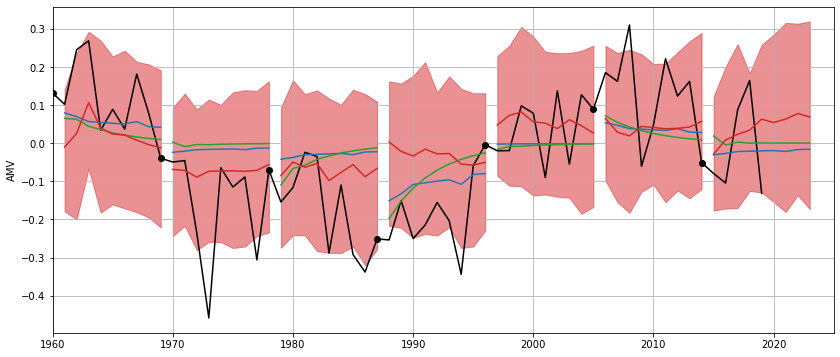

In [217]:
n_steps = 9
var = "AMV"

q = (0.05, 0.95)

fig = plt.figure(figsize=(14, 6))
ax = fig.subplots(1, 1, sharex=True)

reanalysis_plot = reanalysis[var]#.assign_coords({"time": reanalysis.time.dt.year})

ax.plot(reanalysis_plot.time, reanalysis[var], color="k")
for init in hindcast.init.values[:: n_steps]:
    ax.plot(
        init,
        reanalysis_plot.sel(time=init),
        marker="o",
        markersize=6,
        color="k",
    )

    olr_prediction_plot = olr_prediction.sel(init=init).squeeze()

    ax.plot(olr_prediction_plot.lead + init, olr_prediction_plot, color="C0")
    
    ar_prediction_plot = ar_prediction[var].sel(init=init).squeeze()
    ax.plot(ar_prediction_plot.lead + init, ar_prediction_plot, color="C2")

    hindcast_plot = hindcast[var].sel(init=init, lead=slice(n_steps))
    ax.fill_between(
        hindcast_plot.lead + init,
        hindcast_plot.quantile(q[0], "member"),
        hindcast_plot.quantile(q[1], "member"),
        alpha=0.5,
        color="C3",
    )
    ax.plot(hindcast_plot.lead + init, hindcast_plot.mean("member"), color="C3")

    ax.set_ylabel(var)

ax.set_xlim(hindcast.init.min(), hindcast.init.max() + 9)

In [218]:
olr_prediction_acf = stats.acf(
    olr_prediction.sel(lead=slice(2, 9)).mean(["lead"]), dim="init", partial=True
)

ar_prediction_acf = stats.acf(
    ar_prediction.sel(lead=slice(2, 9)).mean(["lead"]), dim="init", partial=True
)

hindcast_acf = stats.acf(
    hindcast.sel(lead=slice(1, 8)).mean(["member", "lead"]), dim="init", partial=True
)

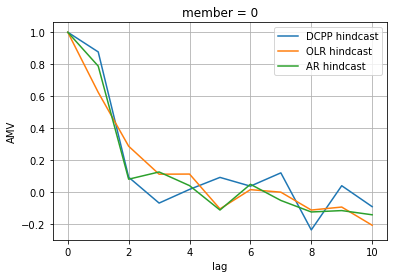

In [219]:
hindcast_acf["AMV"].plot(label="DCPP hindcast")
olr_prediction_acf.plot(label="OLR hindcast")
ar_prediction_acf["AMV"].plot(label="AR hindcast")
plt.legend()

## Fit OLR using reanalysis as the predictor and DCPP hindcast data as the predictand

In [220]:
var = "AMV"

init_values = reanalysis[var].sel(time = hindcast.init.values).rename({"time": "init"})
input_data = hindcast[var].assign_coords({"init_values": init_values})
input_data = input_data.swap_dims({"init": "init_values"})

coeffs = input_data.polyfit(dim="init_values", deg=1)["polyfit_coefficients"].mean("member")
coeffs = coeffs - coeffs.sel(degree=0)

olr_prediction = xr.polyval(input_data.init_values, coeffs)
olr_prediction = olr_prediction.assign_coords({"init": input_data.init}).swap_dims({"init_values": "init"})
olr_prediction = olr_prediction.sel(init=hindcast.init)

(1960.0, 2025.0)

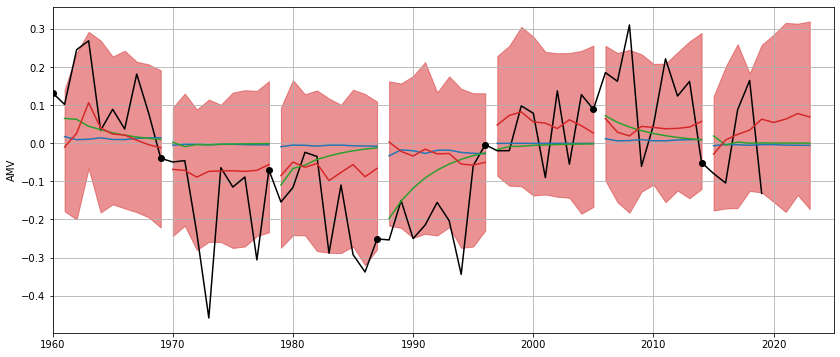

In [221]:
n_steps = 9
var = "AMV"

q = (0.05, 0.95)

fig = plt.figure(figsize=(14, 6))
ax = fig.subplots(1, 1, sharex=True)

reanalysis_plot = reanalysis[var]#.assign_coords({"time": reanalysis.time.dt.year})

ax.plot(reanalysis_plot.time, reanalysis[var], color="k")
for init in hindcast.init.values[:: n_steps]:
    ax.plot(
        init,
        reanalysis_plot.sel(time=init),
        marker="o",
        markersize=6,
        color="k",
    )

    olr_prediction_plot = olr_prediction.sel(init=init).squeeze()

    ax.plot(olr_prediction_plot.lead + init, olr_prediction_plot, color="C0")
    
    ar_prediction_plot = ar_prediction[var].sel(init=init).squeeze()
    ax.plot(ar_prediction_plot.lead + init, ar_prediction_plot, color="C2")

    hindcast_plot = hindcast[var].sel(init=init, lead=slice(n_steps))
    ax.fill_between(
        hindcast_plot.lead + init,
        hindcast_plot.quantile(q[0], "member"),
        hindcast_plot.quantile(q[1], "member"),
        alpha=0.5,
        color="C3",
    )
    ax.plot(hindcast_plot.lead + init, hindcast_plot.mean("member"), color="C3")

    ax.set_ylabel(var)

ax.set_xlim(hindcast.init.min(), hindcast.init.max() + 9)

In [222]:
olr_prediction_acf = stats.acf(
    olr_prediction.sel(lead=slice(2, 9)).mean(["lead"]), dim="init", partial=True
)

ar_prediction_acf = stats.acf(
    ar_prediction.sel(lead=slice(2, 9)).mean(["lead"]), dim="init", partial=True
)

hindcast_acf = stats.acf(
    hindcast.sel(lead=slice(1, 8)).mean(["member", "lead"]), dim="init", partial=True
)

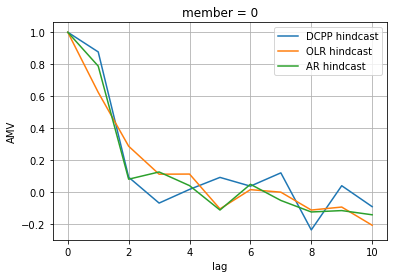

In [223]:
hindcast_acf["AMV"].plot(label="DCPP hindcast")
olr_prediction_acf.plot(label="OLR hindcast")
ar_prediction_acf["AMV"].plot(label="AR hindcast")
plt.legend()

## Of course, linear regression will always just give a weighted sum of the predictor so the ACF will always look the same for the same predictor

## For example: fit OLR using DCPP hindcast lead 1 as the predictor and DCPP hindcast data as the predictand

In [224]:
init_values = hindcast[var].sel(lead=1, drop=True).mean("member")
input_data = hindcast[var].sel(lead=slice(2,None)).assign_coords({"init_values": init_values})
input_data = input_data.assign_coords({"init": input_data.init+1, "lead": input_data.lead-1})
input_data = input_data.swap_dims({"init": "init_values"})

In [226]:
coeffs = input_data.polyfit(dim="init_values", deg=1)["polyfit_coefficients"].mean("member")
coeffs = coeffs - coeffs.sel(degree=0)

# Initialise from the reanalysis
init_values = reanalysis[var].sel(time = hindcast.init.values).rename("time")
init_values = init_values.assign_coords({"time":init_values.values})
olr_prediction = xr.polyval(init_values, coeffs)
olr_prediction = olr_prediction.assign_coords({"time": input_data.init.values}).rename({"time": "init"})

(1960.0, 2025.0)

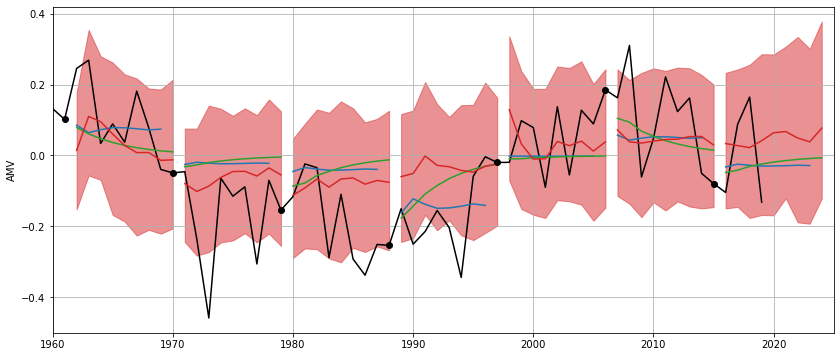

In [227]:
n_steps = 9
var = "AMV"

q = (0.05, 0.95)

fig = plt.figure(figsize=(14, 6))
ax = fig.subplots(1, 1, sharex=True)

reanalysis_plot = reanalysis[var]#.assign_coords({"time": reanalysis.time.dt.year})

ax.plot(reanalysis_plot.time, reanalysis[var], color="k")
for init in olr_prediction.init.values[:: n_steps]:
    ax.plot(
        init,
        reanalysis_plot.sel(time=init),
        marker="o",
        markersize=6,
        color="k",
    )

    olr_prediction_plot = olr_prediction.sel(init=init).squeeze()

    ax.plot(olr_prediction_plot.lead + init, olr_prediction_plot, color="C0")
    
    ar_prediction_plot = ar_prediction[var].sel(init=init).squeeze()
    ax.plot(ar_prediction_plot.lead + init, ar_prediction_plot, color="C2")

    hindcast_plot = hindcast[var].sel(init=init, lead=slice(n_steps))
    ax.fill_between(
        hindcast_plot.lead + init,
        hindcast_plot.quantile(q[0], "member"),
        hindcast_plot.quantile(q[1], "member"),
        alpha=0.5,
        color="C3",
    )
    ax.plot(hindcast_plot.lead + init, hindcast_plot.mean("member"), color="C3")

    ax.set_ylabel(var)

ax.set_xlim(hindcast.init.min(), hindcast.init.max() + 9)

In [228]:
olr_prediction_acf = stats.acf(
    olr_prediction.sel(lead=slice(2, 9)).mean(["lead"]), dim="init", partial=True
)

ar_prediction_acf = stats.acf(
    ar_prediction.sel(lead=slice(2, 9)).mean(["lead"]), dim="init", partial=True
)

hindcast_acf = stats.acf(
    hindcast.sel(lead=slice(1, 8)).mean(["member", "lead"]), dim="init", partial=True
)

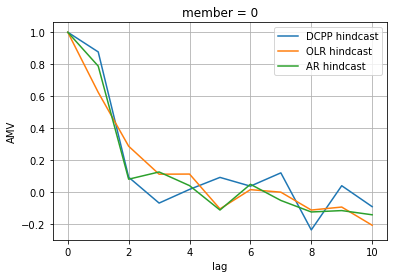

In [229]:
hindcast_acf["AMV"].plot(label="DCPP hindcast")
olr_prediction_acf.plot(label="OLR hindcast")
ar_prediction_acf["AMV"].plot(label="AR hindcast")
plt.legend()

## So linear regression does not (and will never) work, even for different fits. This is also true for a persistence forecast, which is linear regression with unit coefficients

## How different are AR and ARMA models?

In [339]:
var = "NAO"

input_data = reanalysis[var]

In [340]:
from statsmodels.tsa.arima.model import ARIMA

In [370]:
arma_fit = ARIMA(input_data.values, order=(2, 0, 2)).fit()
ar_fit = ARIMA(input_data.values, order=(2, 0, 0)).fit()

In [371]:
n_steps = 9

arma_prediction = np.empty((len(input_data), n_steps))
ar_prediction = np.empty((len(input_data), n_steps))
for i in range(len(input_data)):
    arma_prediction[i, :] = arma_fit.predict(i, i + n_steps - 1, dynamic=True)
    ar_prediction[i, :] = ar_fit.predict(i, i + n_steps - 1, dynamic=True)

arma_prediction = xr.DataArray(
    arma_prediction,
    coords={"init": input_data.time.values, "lead": range(1, n_steps + 1)},
)
ar_prediction = xr.DataArray(
    ar_prediction,
    coords={"init": input_data.time.values, "lead": range(1, n_steps + 1)},
)

(1960.0, 2025.0)

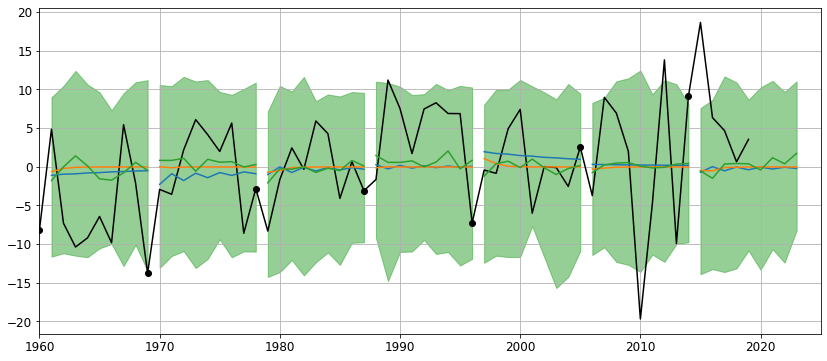

In [372]:
n_steps = 9

q = (0.05, 0.95)

fig = plt.figure(figsize=(14, 6))
ax = fig.subplots(1, 1, sharex=True)

reanalysis_plot = reanalysis[var]

ax.plot(reanalysis_plot.time, reanalysis[var], color="k")
for init in hindcast.init.values[::n_steps]:
    ax.plot(
        init,
        reanalysis_plot.sel(time=init),
        marker="o",
        markersize=6,
        color="k",
    )

    arma_prediction_plot = arma_prediction.sel(init=init).squeeze()
    ax.plot(arma_prediction_plot.lead + init, arma_prediction_plot, color="C0")

    ar_prediction_plot = ar_prediction.sel(init=init).squeeze()
    ax.plot(ar_prediction_plot.lead + init, ar_prediction_plot, color="C1")

    hindcast_plot = hindcast[var].sel(init=init, lead=slice(n_steps))
    ax.fill_between(
        hindcast_plot.lead + init,
        hindcast_plot.quantile(q[0], "member"),
        hindcast_plot.quantile(q[1], "member"),
        alpha=0.5,
        color="C2",
    )
    ax.plot(hindcast_plot.lead + init, hindcast_plot.mean("member"), color="C2")

ax.set_xlim(hindcast.init.min(), hindcast.init.max() + 9)

In [373]:
arma_prediction_acf = stats.acf(
    arma_prediction.sel(lead=slice(1, 8)).mean(["lead"]), dim="init", partial=True
)

ar_prediction_acf = stats.acf(
    ar_prediction.sel(lead=slice(1, 8)).mean(["lead"]), dim="init", partial=True
)

hindcast_acf = stats.acf(
    hindcast.sel(lead=slice(1, 8)).mean(["member", "lead"]), dim="init", partial=True
)

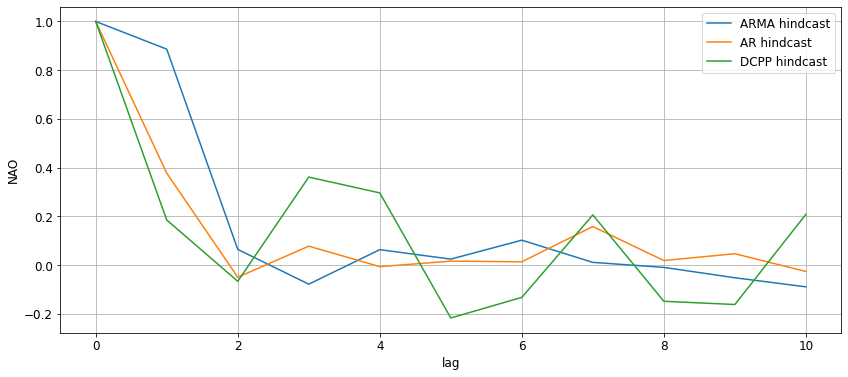

In [374]:
arma_prediction_acf.plot(label="ARMA hindcast")
ar_prediction_acf.plot(label="AR hindcast")
hindcast_acf[var].plot(label="DCPP hindcast")

plt.legend()

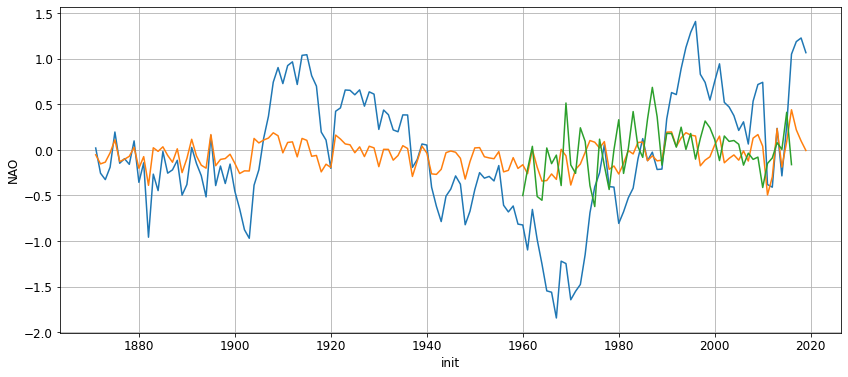

In [375]:
arma_prediction.sel(lead=slice(1, 8)).mean(["lead"]).plot()
ar_prediction.sel(lead=slice(1, 8)).mean(["lead"]).plot()
hindcast[var].sel(lead=slice(1, 8)).mean(["member", "lead"]).plot()

## The ARMA model doesn't respresent the process very well...

Try linear regression fitted to the historical data and ARMA fitted to the historical data